In [560]:
def topo_list(value):
    ans = []
    visited = set()
    def dfs(obj):
        if obj in visited:
            return
        visited.add(obj)
        for v in obj.children:
            ret = dfs(v)
        ans.append(obj)
    dfs(value)
    ans.reverse()
    return ans

In [921]:
import math
class Value:
    
    def __init__(self,data,label='',op='',prev=(),require_grad=True):
        self.data = data
        self.op = op
        self.children = prev
        self.grad = 0
        self.label=label
        self.require_grad = require_grad
    
    def wrap(self,v):
        return  Value(v) if not isinstance(v,Value) else v
    
    def __sub__(self,other):
        other = self.wrap(other)
        return self + (-1)*other
    
    def __rsub__(self,other):
        return  other + (-1)*self

    def __add__(self,other):
        other = self.wrap(other)
        return Value(self.data+other.data,op='+',prev=(self,other))
    
    def __mul__(self,other):
        other = self.wrap(other)
        return Value(self.data*other.data,op='*',prev=(self,other))
    
    def __radd__(self,other):
        return self + other
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        other = self.wrap(other)
        return self * Value(other.data)**(-1)
    
    def __rtruediv__(self,other):
        other = self.wrap(other)
        return other * self**(-1)
    
    def __pow__(self,other):
        other = self.wrap(other)
        return Value(self.data**other.data,op='**',prev=(self,other))
    
    def exp(self):
        return Value(math.e) ** self 
    
    def sigmoid(self):
        e = self.exp()
        g = 1 / e
        return  1 / (1+g)
    
    def _backward(self):
#         print('backward...')
        if self.children:
            c1,c2 = self.children
#             print(self.grad,c1.grad,c2.grad,self.data,c1.data,c2.data)
            if self.op == '*':
                if c1.require_grad:
                    c1.grad += self.grad * c2.data
                if c2.require_grad:
                    c2.grad += self.grad * c1.data
            if self.op == '+':
                if c1.require_grad:
                    c1.grad += self.grad 
                if c2.require_grad:
                    c2.grad += self.grad  
            if self.op == '**':
                if c1.require_grad:
                    c1.grad += self.grad * c2.data * (c1.data ** (c2.data-1))
                if c2.require_grad:
#                     print(c1.data,c2.data,self.grad,'....')
                    c2.grad += self.grad * (c1.data ** c2.data) * math.log(abs(c1.data))
    
    def backward(self):
        topolist = topo_list(self)
        if self.require_grad:
            self.grad = 1
        for o in topolist:
            o._backward()
    
    def __repr__(self):
        return 'Value(data={})'.format(self.data)

In [922]:
a = Value(2)
b = a.sigmoid()

In [923]:
b

Value(data=0.8807970779778823)

In [924]:
b.backward()

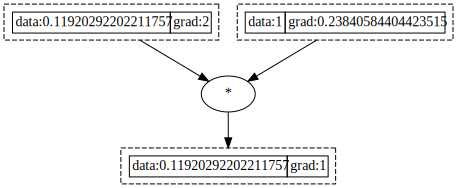

In [916]:
construct_graph(b)

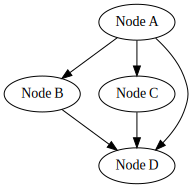

In [819]:
from graphviz import Digraph
from IPython.display import display, SVG

dot = Digraph(comment='Simple Graph')
dot.node('A', 'Node A')
dot.node('B', 'Node B')
dot.node('C', 'Node C')
dot.node('D', 'Node D')
dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('B', 'D')
dot.edge('C', 'D')
dot.edge('A', 'D')

dot.graph_attr.update(style='vertical')
display(SVG(dot.pipe(format='svg')))

In [820]:
def create_label(value1, value2):
    return f'''<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
               <TR><TD>{value1}</TD><TD>{value2}</TD></TR>
               </TABLE>>'''

In [821]:
def construct_graph(root):
    alist = topo_list(root)
    dot = Digraph(comment='Simple Graph')
    otoi = {}
    for i,obj in enumerate(alist):
        otoi[obj] = i
        dot.node(str(i),create_label('data:'+str(obj.data),'grad:{}'.format(str(obj.grad))),shape='box',style='dashed')
        
    for i,obj in enumerate(alist):
        ii = str(i)
        if obj.children:
            c1,c2 = obj.children
            j1,j2 = str(otoi[c1]),str(otoi[c2])
            op = obj.op
            op_key = str(i)+'op'
            dot.node(op_key,op)
            dot.edge(j1,op_key)
            dot.edge(j2,op_key)
            dot.edge(op_key,ii)
    display(SVG(dot.pipe(format='svg')))        

In [925]:
x = 3
y = 0.6
w = Value(0.1)
b = Value(0.1)
parameters = [w,b]
for i in range(1000):
#     print(w,b,x)
    loss = (w * x + b - y).sigmoid()
    #     print(loss)
    for p in parameters:
        p.grad = 0
    loss.backward()
    if i % 10:
        print(loss.data)
    for p in parameters:
        print(p.grad)
        p.data += -0.01*p.grad

0.74254971813558
0.24751657271186
0.4440474168008906
0.7406079253000402
0.24686930843334673
0.4379616865336995
0.7384537429867711
0.24615124766225704
0.4319121863852782
0.7360921489115008
0.24536404963716693
0.42590217672003927
0.7335285377555152
0.24450951258517173
0.41993479531848527
0.7307686889979216
0.2435895629993072
0.41401304981414216
0.7278187331932044
0.24260624439773482
0.4081398110471728
0.7246851170566526
0.24156170568555085
0.40231780735422246
0.7213745677197396
0.2404581892399132
0.3965496198030891
0.7178940565113441
0.23929801883711468
0.7142507626092294
0.2380835875364098
0.3851842590495795
0.7104520368900178
0.23681734563000595
0.37959148187051045
0.7065053662855812
0.23550178876186043
0.3740613097972717
0.7024183389300636
0.23413944631002118
0.3685955484712236
0.6981986103552644
0.23273287011842148
0.3631958467536238
0.693853870963626
0.23128462365454203
0.35786369801988016
0.6893918149782485
0.22979727165941616
0.3526004421522354
0.6848201110388505
0.228273370346283

In [858]:
alist = topo_list(loss)

In [859]:
for o in alist:
    if o is w:
        print(o.grad)
    if o is b:
        print(o.grad)

0.010210631622954906
0.030631894868864716


In [860]:
w

Value(data=-1.212525119302191)

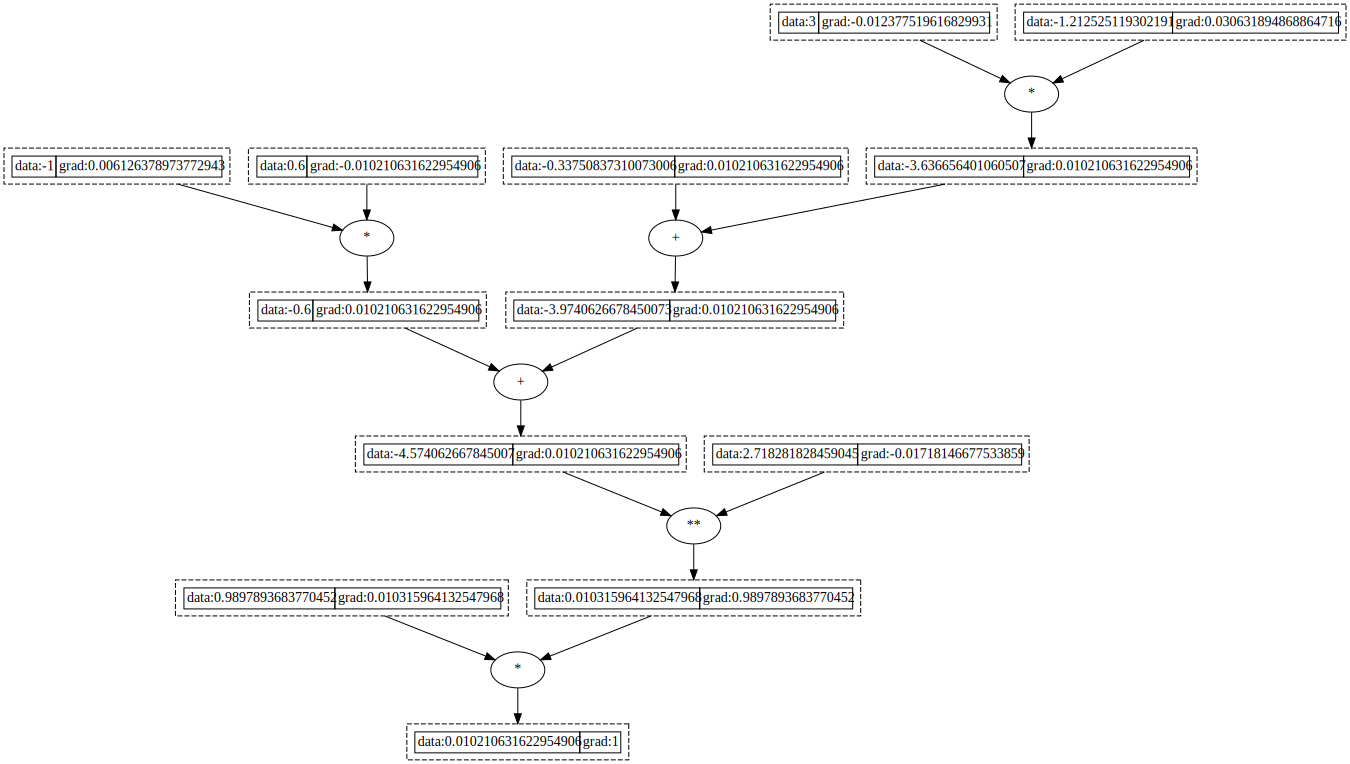

In [861]:
construct_graph(loss)

In [573]:
for _ in range(10):
    x = a - 1
    y = x ** 2
    z = y + 1
    parametrs = [a,x,y,z]
    for p in parametrs:
        p.require_grad = True
    z.backward()
    for p in parametrs:
        p.data += -0.1 * p.grad

In [574]:
import random

In [575]:
random.uniform

<bound method Random.uniform of <random.Random object at 0x12f81ca10>>

In [926]:
class Neuro:
    
    def __init__(self,input_size):
        self.w = [Value(random.uniform(-1,1)) for _ in range(input_size)]
        self.b = [Value(random.uniform(-1,1)) for _ in range(input_size)]
    
    def __call__(self,x):
        # x B,T
        self.out = [sum(wi*vi+bi for vi,wi,bi in zip(v,self.w,self.b)).sigmoid() for v in x]
        return self.out
    
    def parameters(self):
        return self.w + self.b
        

In [790]:
nero = Neuro(4)

In [791]:
x = [[1,2,3,4],[5,4,67,3]]

In [792]:
y=sum(nero(x))

In [793]:
y.backward()

1.0 ....
2.718281828459045 ....
1.0610784247794307 ....
2.718281828459045 ....


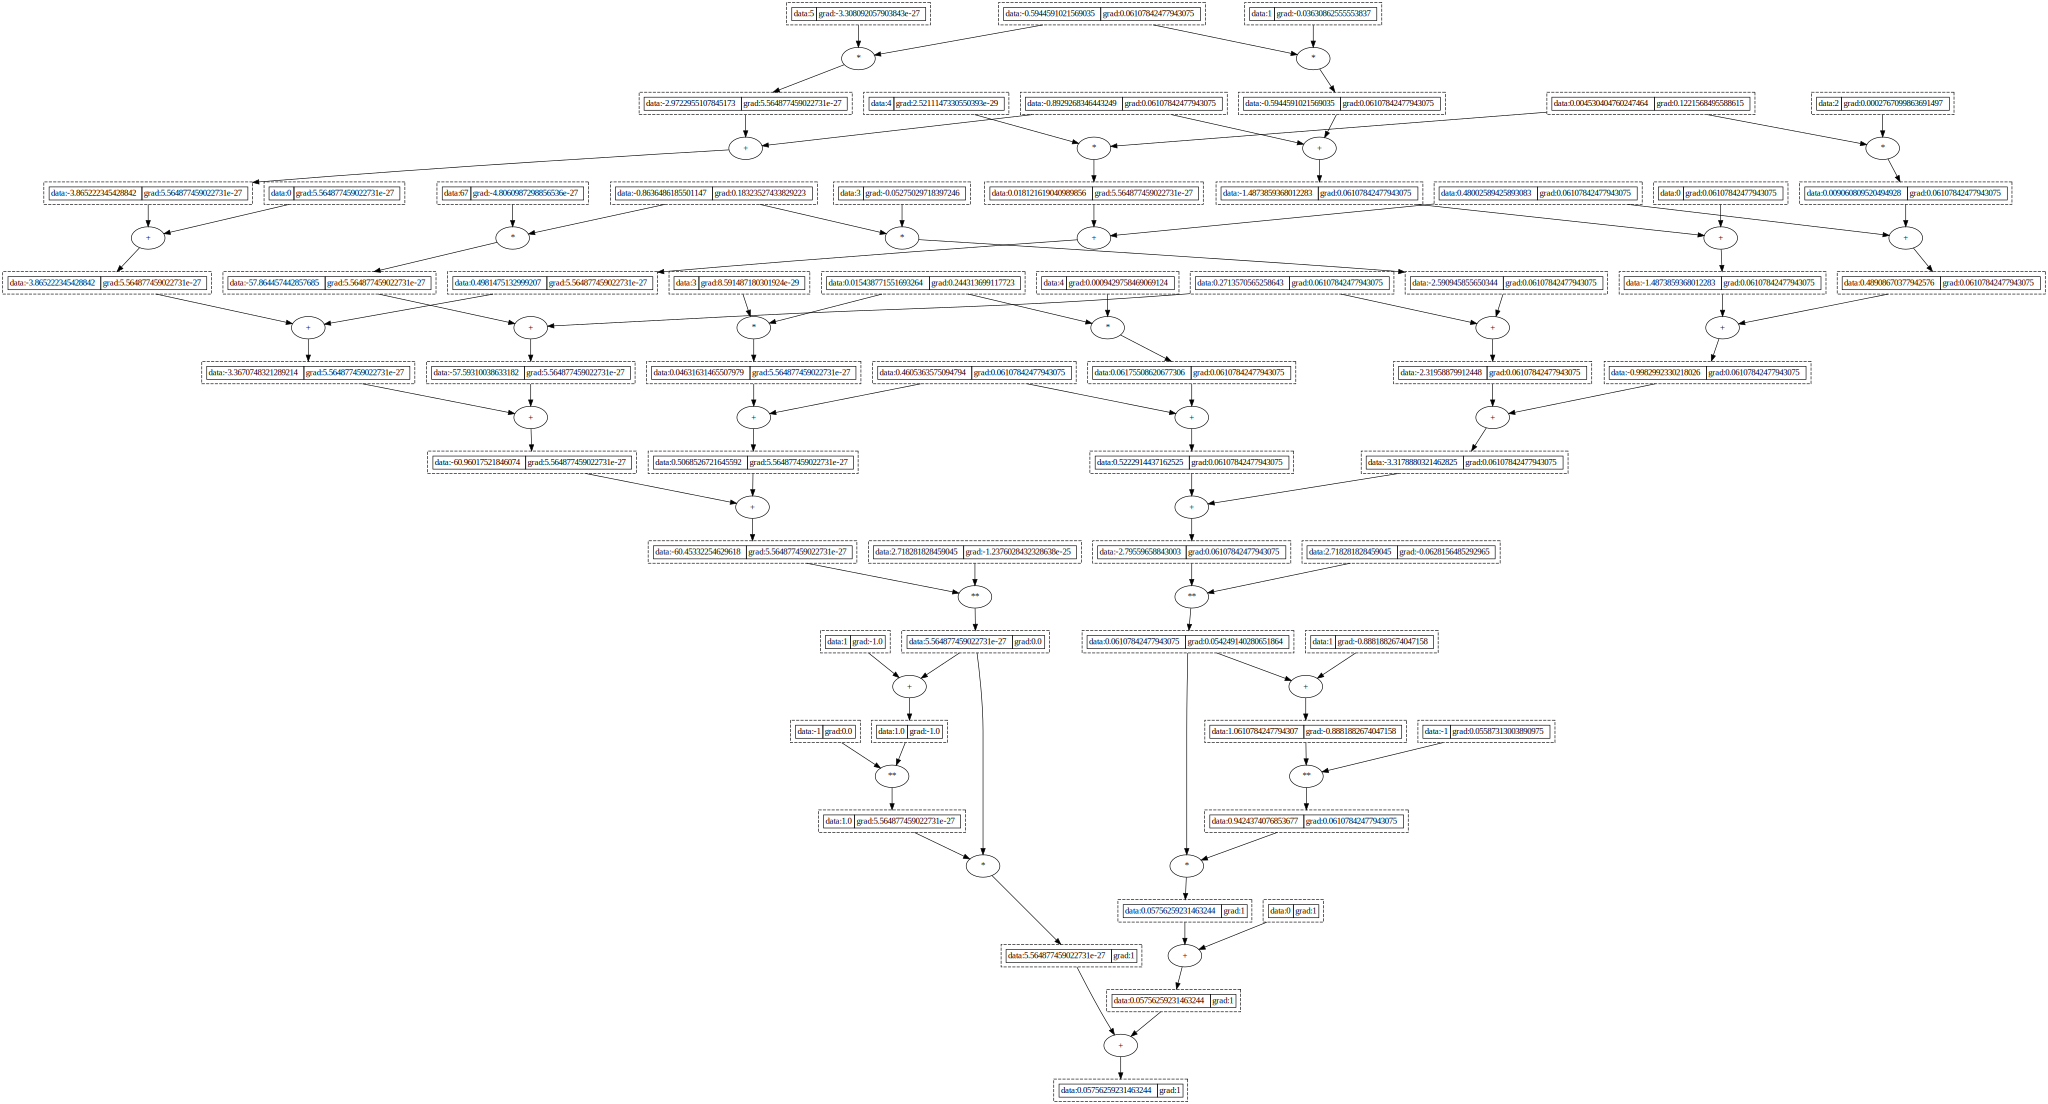

In [794]:
construct_graph(y)

In [927]:
class Layer:
    
    def __init__(self,input_size,output_size):
        self.neuros = [Neuro(input_size) for _ in range(output_size)]
    
    def __call__(self,x):
        # x B,T
        self.out = [[nero([v])[0] for nero in self.neuros] for v in x]
        return self.out
    
    def parameters(self):
        ans = []
        for ner in self.neuros:
            ans.extend(ner.parameters())
        return ans

In [797]:
layer = Layer(4,10)

In [798]:
layer(x)

[[Value(data=0.0009786605017017972),
  Value(data=0.9324118760545086),
  Value(data=0.9966335579059761),
  Value(data=0.007101406411205294),
  Value(data=0.002172345646092308),
  Value(data=0.02315857871799838),
  Value(data=0.9031694264687882),
  Value(data=0.9848684578068525),
  Value(data=0.902427449281037),
  Value(data=0.9822021243944323)],
 [Value(data=1.0813206083207243e-25),
  Value(data=0.9999999999999999),
  Value(data=0.9999999999999092),
  Value(data=1.2386258586136902e-26),
  Value(data=4.80560034940689e-30),
  Value(data=2.5700472415323766e-21),
  Value(data=1.0),
  Value(data=1.0),
  Value(data=0.9999999861341965),
  Value(data=1.0)]]

In [928]:
class MLP:
    
    def __init__(self,input_size,output_size):
        self.layer1 = Layer(input_size,2)
        self.layer2 = Layer(2,1)
        self.layer3 = Layer(1,output_size)
    
    def __call__(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        self.out = self.layer3(x)
        return self.out
    
    def parameters(self):
        ans = []
        for layer in [self.layer1,self.layer2,self.layer3]:
            ans.extend(layer.parameters())
        return ans

In [944]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [4.0, -2.0, 1.5],
  [9.0, -5.0, 7.5] 
]
ys = [1.0,0.0,0.0,1.0]

In [951]:
mlp(xs)

[[Value(data=0.978531965978478)],
 [Value(data=0.017901621132515724)],
 [Value(data=0.017662434221172967)],
 [Value(data=0.9783641191813213)]]

In [948]:
mlp = MLP(3,1)
parameters = mlp.parameters()

In [950]:
for i in range(10000):
    for p in  parameters:
        p.grad = 0
    ypred = mlp(xs)
#     print(ypred)
    loss = sum((yp[0]-y)**2 for yp,y in zip(ypred,ys))
    if i % 1000 == 0:
        print(loss)
    loss.backward()
    for p in parameters:
#         print(p.grad)
        p.data += -0.05*p.grad

Value(data=0.0038388908117473882)
Value(data=0.003356272796614741)
Value(data=0.0029800303696352203)
Value(data=0.002678667364193112)
Value(data=0.002431947665817536)
Value(data=0.0022263021867177566)
Value(data=0.0020523018247630416)
Value(data=0.0019031938574110507)
Value(data=0.0017740164519864275)
Value(data=0.0016610423186321373)


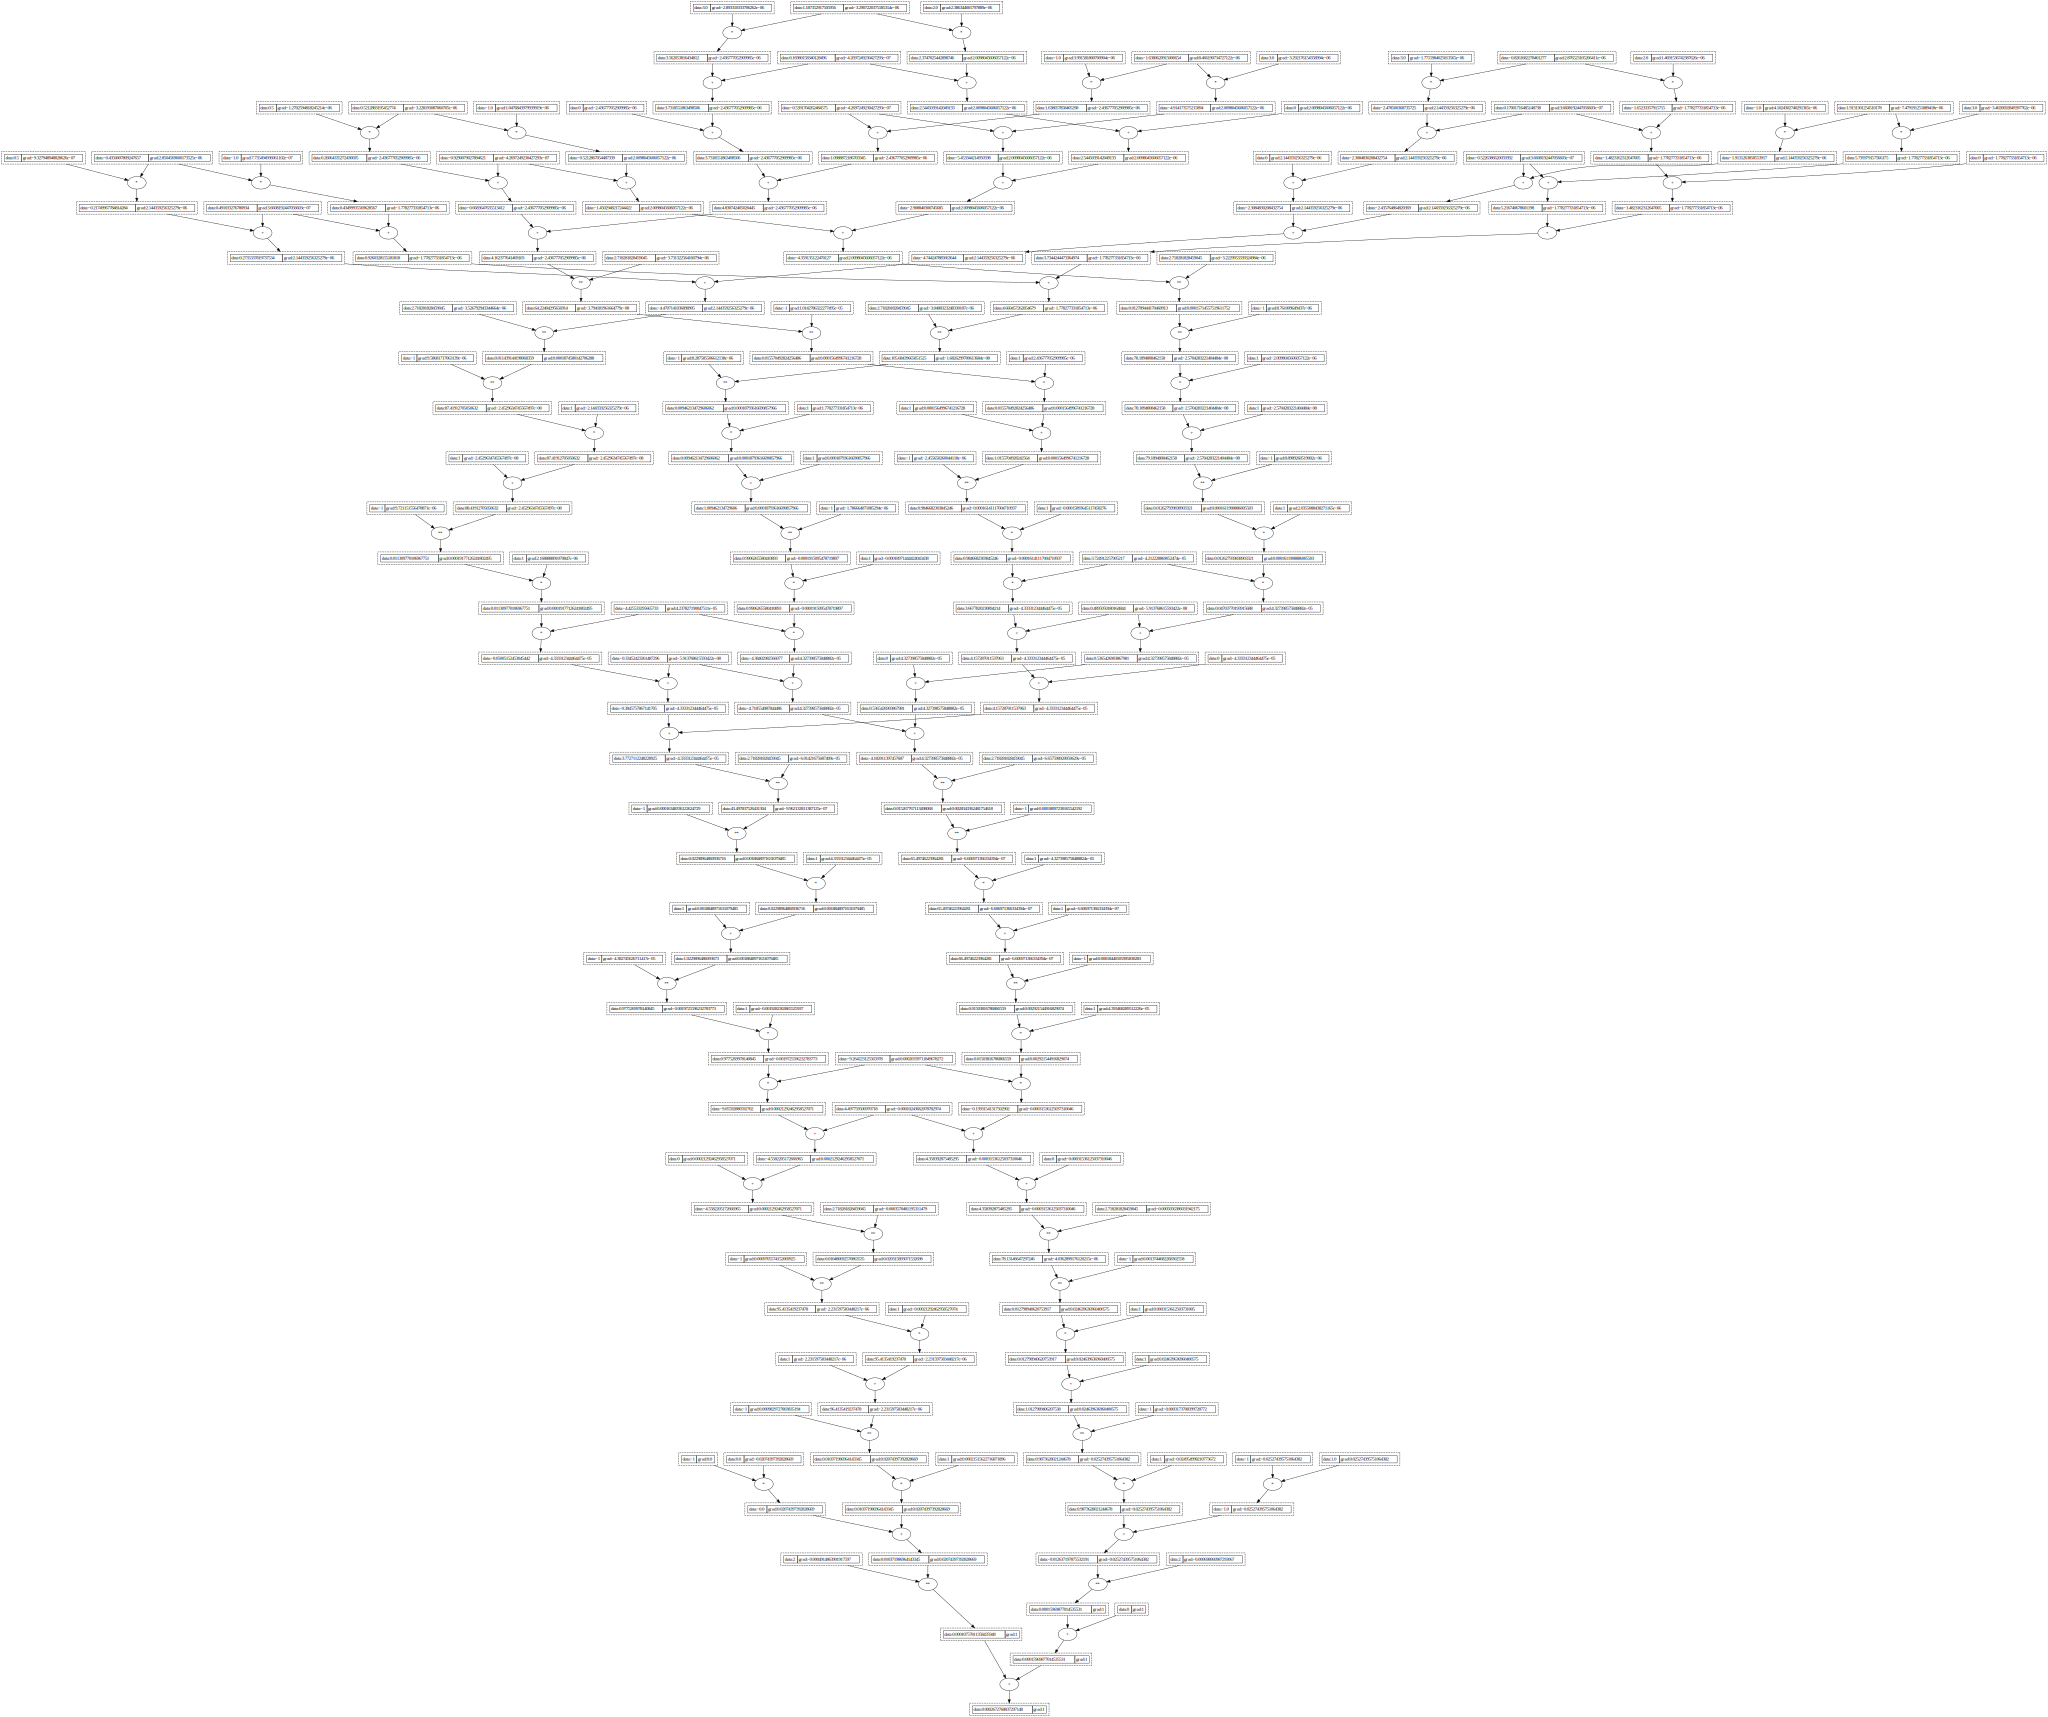

In [936]:
construct_graph(loss)

In [937]:
alist=topo_list(loss)